#Week 5 Pytorch Toy Project 4

Pytorch Trainer (by imjjun 16th)

---

According to the last pytorch toy project, we have just learned how to make customized dataset(dataloader), own model and basic training code!

On this notebook, we would learn some tips to train our own models which are:

- TensorboardX

- Weights & biases

Also, You would implement whole pipeline of Deep Learning with Pytorch, and the main model might be the RNN!

##1. TensorboardX

Tensorboard is a visualization tool of training for Pytorch(& tensorflow). You could visualize the loss, Accuracy on train/valid/test dataset. We could get many insights through this useful tool & We don't need to implement some graphs with `matplotlib` library individually. Let's put into use intuitively.

In [ ]:
#Primarily, pre-define the whole network which was just implemented on 2nd week assignment & some methods

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class examplenet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear=nn.Linear(28*28, 10)
        self.softmax=nn.Softmax()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.softmax(x)

        return x

model = examplenet()

#If we wanna revise your hyperparameters, we could just do that.
learning_rate = 1e-3
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

##1. TensorboardX

We would set-up & write the tensorboard while training. After that, we could finally obtain some visualized results so that we could get some inspections of our model like 'Where is the flaw of our model?'

This automated tool is quite so strong that we could adjust this tool wherever pytorch exists. It would be more comfortable to use pytorch than before.

In [ ]:
#1 Tensorboard Setup
from torch.utils.tensorboard import SummaryWriter

# original directory of tensorboard is 'runs' but we could revise this directory such as 'runs/experiment1'
# If you wanna make many experiments with one model, making such directories is strongly recommended since you have to make lots of tensorboard afterward.
writer = SummaryWriter('runs/experiment1')

In [ ]:
# +) Image Uploading

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록합니다.
writer.add_image('Images on Dataset', img_grid)

In [ ]:
#2 Write the model on Tensorboard
#You could visulaize your Artificial network on Tensorboard
#Plz refer to below code

writer.add_graph(model, images)
writer.close()

You must focus on this part: "trainer". Tensorboard must be added to this part. So carefully watch which part was changed.

In [ ]:
#3 Track the loss of model on Tensorboard

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            writer.add_scalar('training loss',
                            loss,
                            (batch + 1) * len(X))
            #We could add the scalar of loss so that we could finally visulaize the loss plot on tensorboard


Run this code so that you could check the visualized loss plot

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss, optimizer)
   #test_loop(test_dataloader, model, loss)
print("Done!")

From now on, you can access the website, which would be shown below like: http://localhost:####.

Then, you could see whole results quickly :) If we add more scalars such as ValidLoss or Test loss and some evaluation metrics, we could enjoy more visualized insights as much as possible!

In [ ]:
%load_ext tensorboard #For colab #If you run this notebook in local, you don't need to make up this code. Just use the below code
%tensorboard --logdir=runs/experiment1 #You have to assign the directory of tensorboard

#2 Weight & Biases (WandB)

This is an online platform for Deep learning Training. Additionally, it stores some artifacts(i.e. weights) so that we don't need to store your weights by ourselves.

Weight storing(checkpoint) is very important since there are lots of case to be an optimal case. Training forever doesn't guarantee performace-up. Therefore, using WandB might be an another solution to get some insights & pre-trained weights either.

In [ ]:
#Install wandb
!pip install wandb

For below cell, we have to sign up for Wandb official website & copy-paste your own API from your profile.

we could enroll our account here: https://wandb.ai/site

In [ ]:
import wandb

wandb.login()

In [ ]:
run = wandb.init(

    project="project 1",

    #Make configuration
    #In deep learning, configuration means the set of hyperparameters. You could include something that we should determine such as epochs, learning_rate, weight decay, batch size and seed etc.
    #As you know, if we wanna obtain same result through randomized & augmented network, we have to fix the seed !
    config={
        "learning_rate": 0.01,
        "epochs": 10,
    },
    reinit=True
    )

wandb.watch(model)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        pred = model(X)
        loss = loss_fn(pred, y)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            #Revision of your training code as below:
            wandb.log({ "Training_loss": loss}) #You can record your log here


In [ ]:
#Then, enjoy your wandb!
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss, optimizer)
    #pytorch method for saving model's weight
    torch.save(model.state_dict(), '/content/model.pth')
    # Save as artifact for version control.
    artifact = wandb.Artifact('model', type='model')
    artifact.add_file('/content/model.pth')

   #test_loop(test_dataloader, model, loss)
print("Done!")

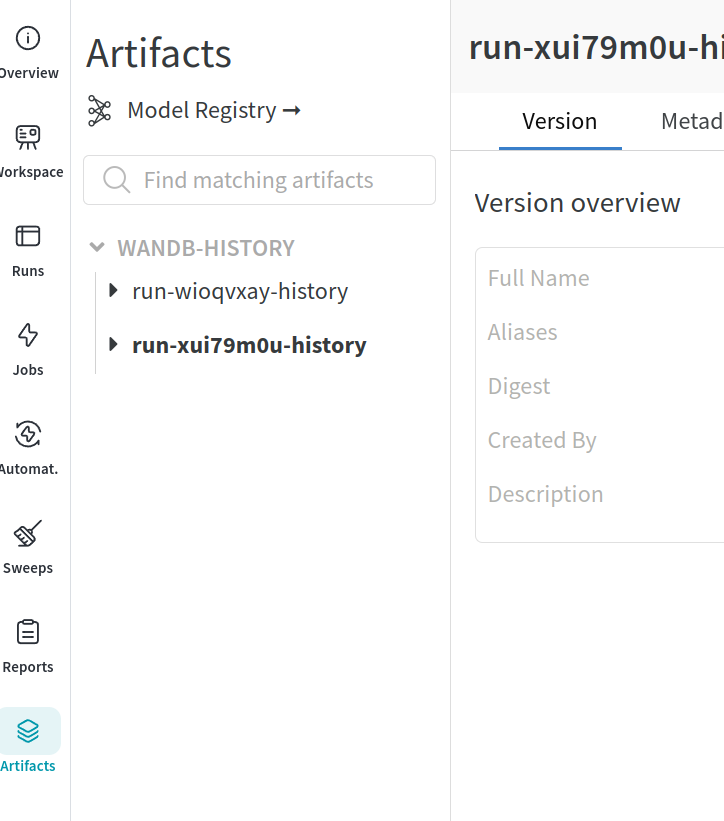

We could find some artifacts here!

#3. Enjoy your pytorch using whole things that we have learned!

We can finally use the RNN & LSTM layers that are already given by pytorch. Compared to implemented one of numpy, which should be stacked by ourselves, we could just pre-define the number of layers and use it. Let's see some codes with official explanation of pytorch docs.

RNN: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [ ]:
rnn = nn.RNN(10, 20, 2) #input_size, hidden_size, num_layers
#nn.RNN(input_size = the number of features in the input x
#       hidden_size = the number of features in the hidden state h
#       num_layers = the number of recurrent layers(RNN cells)
#       nonlinearity = tanh(default) or relu
#       bias = True / False
#       batch_first = input shape (batch, seq, feature) or (seq, batch, feature)
#       dropout
#       bidirectional = training techniques(would be handled later, ex.BERT)
#       )

In [ ]:
lstm = nn.LSTM(10,20,2) #input_size, hidden_size, num_layers
#nn.LSTM(input_size = the number of features in the input x
#       hidden_size = the number of features in the hidden state h
#       num_layers = the number of recurrent layers(RNN cells)
#       bias = True / False
#       batch_first = input shape (batch, seq, feature) or (seq, batch, feature)
#       dropout
#       bidirectional = training techniques(would be handled later, ex.BERT)
#       proj_size = LSTM with projections of corresponding size -> change output's size(kind of linear transformation)
#       )

Since we have learned the whole pipeline of Deep Learning Training & but still not familiar( lol 🤐 ), we would follow-up the code which had been written by Wandb! Here is the original reference of this notebook: https://colab.research.google.com/gist/SauravMaheshkar/168f0817f0cd29dd4048868fb0dd4401/lstms-in-pytorch.ipynb#scrollTo=zxlsEhz4w3mT

Below code might be same with above link's notebook.

All we should do is to change this LSTM code to RNN Code with same Dataset. Pytorch has lots of other libraries such as torchvision, torchtext etc.

In this notebook, with torchtext's dataset, we might train our own RNN model with WandB! We should do something deeper as below:

- [Mandatory] **LSTM -> RNN**: `nn.LSTM -> nn.RNN`
- [Mandatory] **Analysis of Dataset** => You should show some insights like 'What does it look like?' or 'The length of whole dataset & label?'

- [Optional] **WandB -> TensorBoard**: How about using `tensorboard`?
- [Optional] **Make some comments on helper functions & others**

Good luck with all of us :>

##1 Setup Cell

In [ ]:
%%capture

## Install the latest version of wandb client 🔥🔥
!pip install -q --upgrade wandb
!pip install torchtext

import torch
from torch import nn
import torch.nn.functional as F
from torchtext.legacy import data
from torch.autograd import Variable
from torchtext.legacy import datasets
from torchtext.vocab import Vectors, GloVe

In [ ]:
import os
import wandb

# Paste your api key here
os.environ["WANDB_API_KEY"] = '...'

# Feel free to change these and experiment !!
config = wandb.config
config.learning_rate = 2e-5
config.batch_size = 32
config.output_size = 2
config.hidden_size = 256
config.embedding_length = 300
config.epochs = 10

##2 Dataset

How about Dataset? Please give your insight in this notebook. What is our task?

In [ ]:
# Ported from: https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/load_data.py

def load_dataset(test_sen=None):

    tokenize = lambda x: x.split()
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=200)
    LABEL = data.LabelField()
    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
    TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
    LABEL.build_vocab(train_data)

    word_embeddings = TEXT.vocab.vectors #Word Embedding means the vectorization version of NLP since computer couldn't understand the language literally. We should convert NL into some numbers, which must be some tensors

    train_data, valid_data = train_data.split()
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                   batch_size=32,
                                                                   sort_key=lambda x: len(x.text),
                                                                   repeat=False, shuffle=True)

    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter

TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_dataset()

##3 Model

We should change the main hero to our hero, RNN.

In [ ]:
class LSTMClassifier(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
		super(LSTMClassifier, self).__init__()
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length

		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False)
		self.lstm = nn.LSTM(embedding_length, hidden_size) # Our main hero for this tutorial
		self.label = nn.Linear(hidden_size, output_size)

	def forward(self, input_sentence, batch_size=None):
		input = self.word_embeddings(input_sentence)
		input = input.permute(1, 0, 2)
		if batch_size is None:
			h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
		else:
			h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
		final_output = self.label(final_hidden_state[-1])

		return final_output

##4 Training (with helper function)


Why do we just make the function of training, not making it directly?

-> Actually, we must do lots of experiment with some models, which means we control many **hyperparameters** so that optimized model would be returned. Instantiation of Training code is more efficient than that.

In [ ]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

def train_model(model, train_iter, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not 32):
            continue
        optim.zero_grad()
        prediction = model(text)
        loss = loss_fn(prediction, target)
        wandb.log({"Training Loss": loss.item()})
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        wandb.log({"Training Accuracy": acc.item()})
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1

        if steps % 100 == 0:
            print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')

        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] is not 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            loss = loss_fn(prediction, target)
            wandb.log({"Evaluation Loss": loss.item()})
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            wandb.log({"Evaluation Accuracy": acc.item()})
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)

In [ ]:
model = LSTMClassifier(config.batch_size, config.output_size, config.hidden_size, vocab_size, config.embedding_length, word_embeddings)
loss_fn = F.cross_entropy

# Create a wandb run to log all your metrics
# You must define your own name in the init function !
run = wandb.init(project='...', entity='...', reinit=True)

wandb.watch(model)

for epoch in range(config.epochs):
    train_loss, train_acc = train_model(model, train_iter, epoch)
    val_loss, val_acc = eval_model(model, valid_iter)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')

run.finish()

**End of this notebook**